In [1]:
library(tidyverse)
library(cowplot)
theme_set(theme_cowplot())

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

rslt <- '../results/'
detected_palette <- c('Yes' = 'grey80', 'No' = '#e31a1c')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
snp_compare <- function(ds) {
    
    wBiofilter <- read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'with Biofilter') %>%
        select(uniq_snp_id, pvalue) %>%
        unique
    
    woBiofilter <- read_csv(paste0(rslt, 'withoutBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'without Biofilter') %>%
        select(uniq_snp_id, pvalue) %>%
        unique

    full_join(wBiofilter, woBiofilter, by = 'uniq_snp_id', suffix = c('_wBiofilter', '_woBiofilter')) %>%
        mutate(where = ds,
               wBiofilter = ifelse(!is.na(pvalue_wBiofilter), 'Yes', 'No'),
               woBiofilter = ifelse(!is.na(pvalue_woBiofilter), 'Yes', 'No'))
    
}

snp_comparison <- bind_rows(snp_compare('Chromatin'),
                            snp_compare('eQTL'),
                            snp_compare('eqtl_chrom'),
                            snp_compare('eqtl_chrom_phys')) %>%
    mutate(where = ifelse(where == 'eqtl_chrom', 'eQTL +\nchromatin', where),
           where = ifelse(where == 'eqtl_chrom_phys', 'eQTL +\nchromatin +\nphysical', where)) %>%
    filter(wBiofilter == 'Yes') %>%
    ggplot(aes(x = where, fill = woBiofilter)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Significant SNP pairs', fill = 'Detected without Biofilter') +
        theme_bw() +
        theme(legend.position = 'bottom') +
        scale_fill_manual(values = detected_palette)

In [3]:
gene_compare <- function(ds) {
    
    wBiofilter <- read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'with Biofilter') %>%
        select(uniq_gene_id, where)
    woBiofilter <- read_csv(paste0(rslt, 'withoutBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'without Biofilter') %>%
        select(uniq_gene_id, where)

    full_join(wBiofilter, woBiofilter, by = 'uniq_gene_id', suffix = c('_wBiofilter', '_woBiofilter')) %>%
        mutate(ds = ds,
               wBiofilter = ifelse(!is.na(where_wBiofilter), 'Yes', 'No'),
               woBiofilter = ifelse(!is.na(where_woBiofilter), 'Yes', 'No'))
    
}

gene_comparison <- bind_rows(gene_compare('Chromatin'),
                             gene_compare('eQTL'),
                             gene_compare('eqtl_chrom'),
                             gene_compare('eqtl_chrom_phys')) %>%
    mutate(ds = ifelse(ds == 'eqtl_chrom', 'eQTL +\nchromatin', ds),
           ds = ifelse(ds == 'eqtl_chrom_phys', 'eQTL +\nchromatin +\nphysical', ds)) %>%
    filter(wBiofilter == 'Yes') %>%
    ggplot(aes(x = ds, fill = woBiofilter)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Significant gene pairs', fill = 'Detected without Biofilter') +
        theme_bw() +
        theme(legend.position = 'none') +
        scale_fill_manual(values = detected_palette)

In [4]:
read_snps <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        select(uniq_snp_id, pvalue, where) %>%
        unique
    
}

filter_snp <- bind_rows(read_snps('chromatin'),
                        read_snps('eqtl'),
                        read_snps('eqtl_chrom'),
                        read_snps('eqtl_chrom_phys')) %>%
    mutate(where = ifelse(where == 'chromatin', 'chrom', where)) %>%
    group_by(uniq_snp_id) %>%
    summarize(eQTL = ifelse('eqtl' %in% where, 
                            ifelse(any(grepl('chrom', where)), 
                                   ifelse(any(grepl('phys', where)), 
                                          'eQTL + chromatin + physical',
                                          'eQTL + chromatin'),
                                   'eQTL only'), 
                            '-'),
              Chromatin = ifelse('chrom' %in% where, 
                                 ifelse(any(grepl('eqtl', where)),
                                        ifelse(any(grepl('phys', where)), 
                                               'eQTL + chromatin + physical',
                                               'eQTL + chromatin'),
                                        'Chromatin only'),
                                 '-')) %>%
    gather(key = 'where', value = 'counts', -uniq_snp_id) %>%
    filter(counts != '-') %>%
    mutate(counts = factor(counts, levels = c('eQTL only', 'Chromatin only', 
                                              'eQTL + chromatin', 'eQTL + chromatin + physical'))) %>%
    ggplot(aes(x = where, fill = counts)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Counts', fill = 'Protocol') +
        scale_fill_manual(values = c('eQTL only' = '#e34a33', 'Chromatin only' = '#e34a33',
                                     'eQTL + chromatin' = 'gray80', 'eQTL + chromatin + physical' = 'gray60',
                                     'Chromatin + eQTL' = 'gray80')) +
        theme_bw() +
        theme(legend.position = 'bottom')

In [5]:
read_genes <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs_withoutThreshold.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        select(uniq_gene_id, where) %>%
        unique
    
}

filter_genes <- bind_rows(read_genes('chromatin'),
                        read_genes('eqtl'),
                        read_genes('eqtl_chrom'),
                        read_genes('eqtl_chrom_phys')) %>%
    mutate(where = ifelse(where == 'chromatin', 'chrom', where)) %>%
    group_by(uniq_gene_id) %>%
    summarize(eQTL = ifelse('eqtl' %in% where, 
                            ifelse(any(grepl('chrom', where)), 
                                   ifelse(any(grepl('phys', where)), 
                                          'eQTL + chromatin + physical',
                                          'eQTL + chromatin'),
                                   'eQTL only'), 
                            '-'),
              Chromatin = ifelse('chrom' %in% where, 
                                 ifelse(any(grepl('eqtl', where)),
                                        ifelse(any(grepl('phys', where)), 
                                               'eQTL + chromatin + physical',
                                               'eQTL + chromatin'),
                                        'Chromatin only'),
                                 '-')) %>%
    gather(key = 'where', value = 'counts', -uniq_gene_id) %>%
    filter(counts != '-') %>%
    mutate(counts = factor(counts, levels = c('eQTL only', 'Chromatin only', 
                                              'eQTL + chromatin', 'eQTL + chromatin + physical'))) %>%
    ggplot(aes(x = where, fill = counts)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Counts', fill = 'Protocol') +
        scale_fill_manual(values = c('eQTL only' = '#e34a33', 'Chromatin only' = '#e34a33',
                                     'eQTL + chromatin' = 'gray80', 'eQTL + chromatin + physical' = 'gray60',
                                     'Chromatin + eQTL' = 'gray80')) +
        theme_bw() +
        theme(legend.position = 'none')

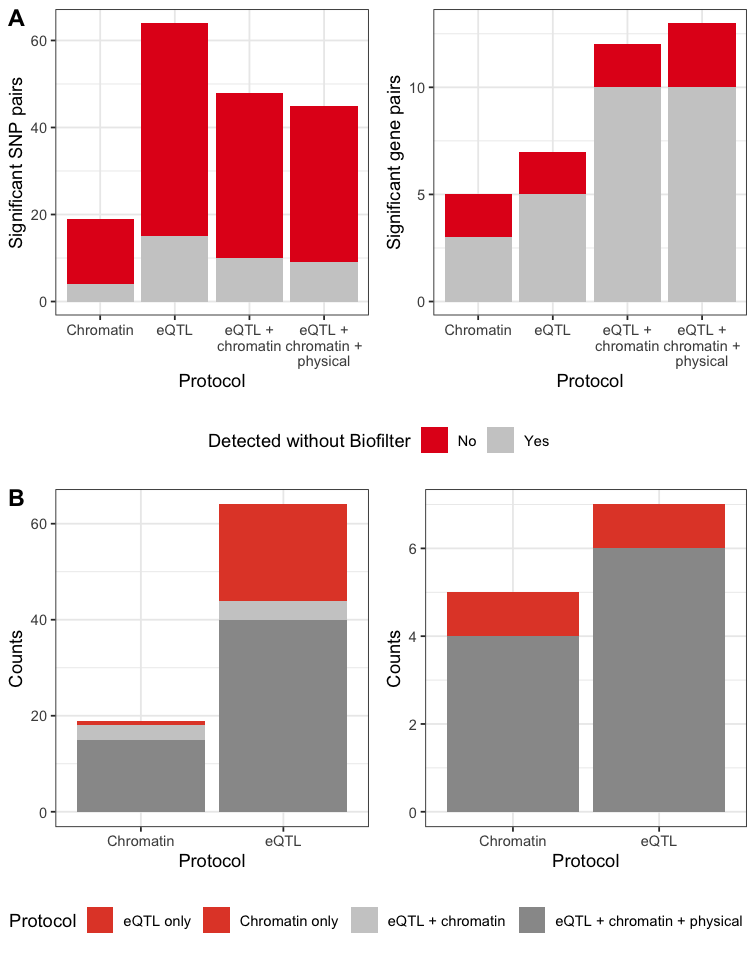

In [6]:
options(repr.plot.width=6.3, repr.plot.height=8)
plot_grid(plot_grid(plot_grid(snp_comparison + theme(legend.position = 'none'), 
                              gene_comparison),
                    get_legend(snp_comparison),
                    nrow = 2, rel_heights = c(5,1)),
          plot_grid(plot_grid(filter_snp + theme(legend.position = 'none'),
                              filter_genes),
                    get_legend(filter_snp),
                    nrow = 2, rel_heights = c(5,1)),
          nrow = 2, labels = c('A','B'))
ggsave(filename = 'fig/superset_comparison.pdf', width=6.3, height=8, bg = "transparent")